## Performance Ablation


Baseline: padding, schnet without FSS, 0 prefetch depth, sync loader, default all reduce
+ packing
+ using async data loader
+ cycle optimisations (use optimised softplus and merge all reduce collectives)
+ increase the prefetch depth to pull data in from the host as early as possible

In [1]:
%matplotlib inline

In [2]:
import torch
import wandb
import matplotlib.pyplot as plt
from warnings import warn
import pandas as pd


def sweep_dataframe(sweep_id):
    api = wandb.Api()

    # Project is specified by <entity/project-name>
    sweep = api.sweep(sweep_id)
    num_runs = len(sweep.runs)

    epoch_times = []
    loss_mean = []
    num_graphs = []

    for run in sweep.runs:
        df = run.history()
        if "train/self_time" not in df.keys():
            warn(f"Skipping crashed run\n{run.config} ")
            continue

        et = df["train/self_time"]
        et = et[~et.isnull()].reset_index(drop=True)
        et = et.rename(run.name)
        epoch_times.append(et)

        loss = df["train/loss_mean"]
        num_graphs.append(run.summary.get("num_processed"))

    df = pd.concat(epoch_times, axis=1)
    mean_time = df.mean().rename("mean_time (s)")
    N = pd.Series(num_graphs, name="N", index=mean_time.index)
    tput = pd.Series(N / mean_time, name="Throughput (graphs / s)")

    df = pd.concat((mean_time, tput), axis=1)
    scaled = df / df[df.index == "Baseline"].values
    names = zip(scaled.columns, ["Time / Baseline", "Throughput / Baseline"])
    scaled.rename(columns=dict(names), inplace=True)
    return pd.concat((df, scaled), axis=1)


def make_plot(df, name):
    h = plt.figure()
    h.suptitle(f"Performance ablation for {name}")

    ax = plt.subplot(1, 2, 1)
    df["Throughput / Baseline"].plot(kind="bar", ax=ax)

    ax = plt.subplot(1, 2, 2)
    df["Time / Baseline"].plot(kind="bar", ax=ax)

## HydroNet 4.5m

In [3]:
df = sweep_dataframe("hatemh/hydronet-large-perf-ablation/sweeps/wycq0zkd")
df

,mean_time (s),Throughput (graphs / s),Time / Baseline,Throughput / Baseline
Prefetch,36.045365,93877.867535,0.677011,1.400199
DeviceOptimisations,37.011482,91427.736134,0.695157,1.363655
Asyncio,41.802359,80949.642682,0.785140,1.207373
Packing,43.278278,78189.339469,0.812861,1.166203
Baseline,53.241934,67046.099069,1.000000,1.000000


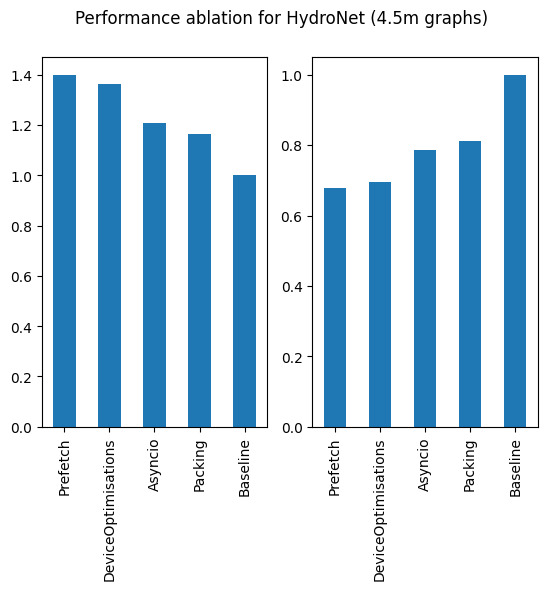

In [4]:
make_plot(df, "HydroNet (4.5m graphs)")

## HydroNet Medium (2.7m)

In [5]:
df = sweep_dataframe("hatemh/hydronet-medium-perf-ablation/sweeps/i0kz7qc6")
df

,mean_time (s),Throughput (graphs / s),Time / Baseline,Throughput / Baseline
DeviceOptimisations,22.153192,96739.241664,0.725955,1.354745
Prefetch,21.847762,98090.596491,0.715946,1.373670
Asyncio,25.880274,82802.834270,0.848091,1.159578
Packing,25.357528,84509.342379,0.830961,1.183477
Baseline,30.515924,71407.702781,1.000000,1.000000


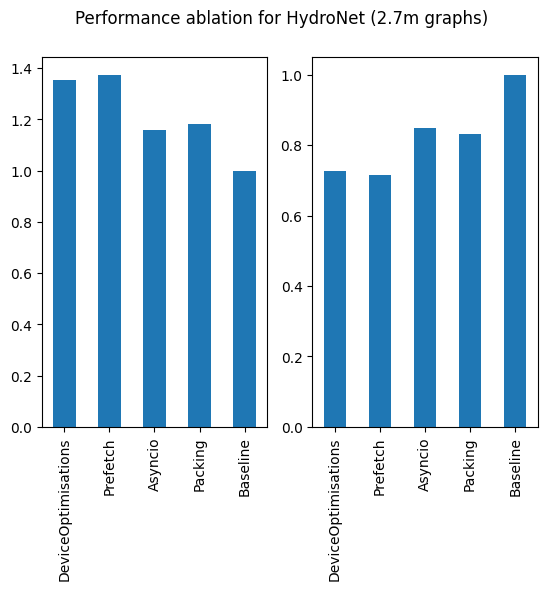

In [6]:
make_plot(df, "HydroNet (2.7m graphs)")

## HydroNet Small (500k)

In [7]:
df = sweep_dataframe("hatemh/hydronet-small-perf-ablation/sweeps/ana1egcv")
df

,mean_time (s),Throughput (graphs / s),Time / Baseline,Throughput / Baseline
Prefetch,6.177819,62217.103695,0.832946,1.192165
DeviceOptimisations,5.857976,65611.567506,0.789822,1.257207
Asyncio,6.667140,57654.406257,0.898921,1.104737
Packing,6.745870,56980.196606,0.909536,1.091819
Baseline,7.416829,52188.339009,1.000000,1.000000


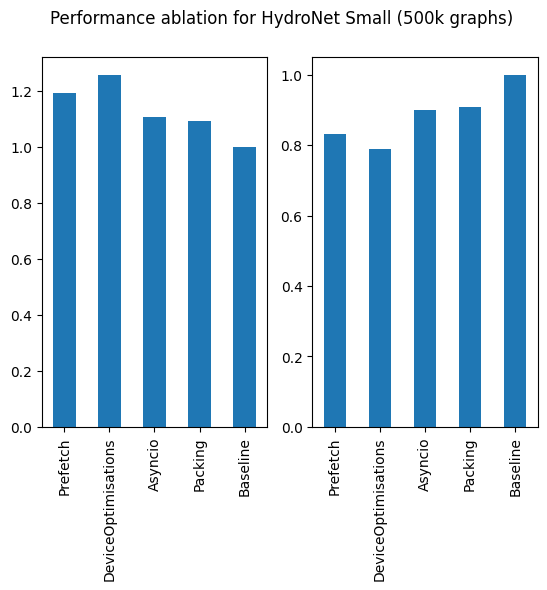

In [8]:
make_plot(df, "HydroNet Small (500k graphs)")

## QM9

In [9]:
df = sweep_dataframe("hatemh/qm9-perf-ablation/sweeps/ei441b4g")
df

,mean_time (s),Throughput (graphs / s),Time / Baseline,Throughput / Baseline
Baseline,1.515820,68905.297526,1.000000,1.000000
Prefetch,0.826615,123878.645413,0.545326,1.797810
DeviceOptimisations,0.778376,131556.026677,0.513501,1.909229
Asyncio,1.045804,97915.071645,0.689927,1.421009
Packing,1.220799,83879.492194,0.805372,1.217316


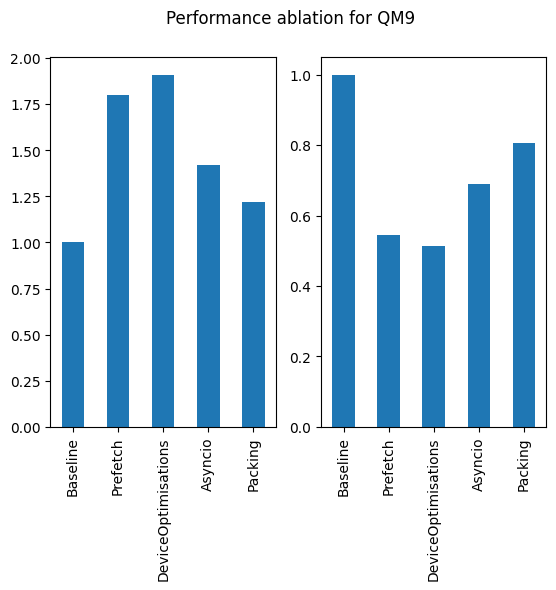

In [10]:
make_plot(df, "QM9")